# Week 15 Project


In [1]:
#Dependencies
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#modules for statistics
import math
import statistics
from scipy import stats

# Generate Artists List

In [3]:
# Find a code to get all the artists from this api
# https://www.theaudiodb.com/api_guide.php
# theaudiodb.com/api/v1/json/1/search.php?s=coldplay

# empty list to be populated with artist names
artist_names = []

In [4]:
#generate random numbers in the range of available artist IDs
#used to populate artist_names list
random_nums = np.random.randint(low=100000, high=170000, size=1000, randon_state=42)

#test with known IDs and intentional errors
#random_nums = [112024, 0, 100000, 114364]

In [5]:
#create a base url
#example: https://theaudiodb.com/api/v1/json/1/artist.php?i=112024
id_url = "https://theaudiodb.com/api/v1/json/1/artist.php?i="

#create a loop that uses random numbers list
for num in random_nums:
    unique_url = id_url + f'{num}'
    
    #call api url
    request = requests.get(unique_url)
    
    #for each attempt try to convert information to json
    try:
        #convert to json
        info = request.json()
        
    #exception json decode error
    #https://docs.python.org/3/tutorial/controlflow.html
    except json.JSONDecodeError:
        #end this iteration and continue new iteration of for loop
        continue
    #if json conversion successful then
    #try to create a variable for single artist to reference later
    try:
        artist = info['artists'][0]['strArtist']
        
    #TypeError exception if url responds with {'artists': None}
    except (TypeError):
        continue
        
    #if the artist is not already in the list then 
    if artist not in artist_names:
        
        #populate artist_names list using info(json)
        #response-> {'artists': [{'idArtist': '114364', 'strArtist': 'Beyoncé', ...
        #dictionary{'artists':['{dictionary}']}
        artist_names.append(info['artists'][0]['strArtist'])
    
    #print(artist_names)

In [6]:
#The number of artists in the list
len(artist_names)

764

# Generate Dictionary of Artist Data

In [7]:
#create loop to pull artist information from the database
#using populated artist_names list
#example url: http://theaudiodb.com/api/v1/json/1/search.php?s=coldplay
#tutorial: https://www.youtube.com/watch?v=pxofwuWTs7c

#create empty dictionary to fill with values
audio_data = {'artist_id':[],
              'artist_name':[],
              'gender':[],
              'members':[],
              'style':[], 
              'genre':[],
             'year_formed':[],
             'year_disbanded':[],
             'location':[]}

#for each artist in the artist list, 
for name in artist_names:
    
    #add the artist name to the base url
    base_url = "http://theaudiodb.com/api/v1/json/1/search.php?s="
    req = requests.get(base_url + f'{name}')
    
    #convert request information into json as a variable
    data = req.json()
    
    #add json values to dictionary
    try:
        audio_data['artist_id'].append(data['artists'][0]['idArtist'])
        audio_data['artist_name'].append(data['artists'][0]['strArtist'])
        audio_data['gender'].append(data['artists'][0]["strGender"])
        audio_data['members'].append(data['artists'][0]["intMembers"])
        audio_data['style'].append(data['artists'][0]["strStyle"])
        audio_data['genre'].append(data['artists'][0]["strGenre"])
        audio_data['year_formed'].append(data['artists'][0]["intFormedYear"])
        audio_data['year_disbanded'].append(data['artists'][0]["strDisbanded"])
        audio_data['location'].append(data['artists'][0]["strCountry"])
    
    #restart loop if TypeError found
    except (TypeError):
        continue

#### Convert Dictionary to DataFrame

In [8]:
audio_df = pd.DataFrame(audio_data)
audio_df.head(5)

artist_id      artist_name  gender members style genre year_formed  \
0    151479    Angèle Dubeau    None    None  None              1962   
1    159955  Psychotic Waltz               1                    1986   
2    154348              張芸京  Female       1                    1983   
3    143286         Fallulah  Female       1        Folk        None   
4    137170  Clémence Lhomme  Female       1  Folk   Pop        1989   

  year_disbanded                 location  
0           None                     None  
1           None                           
2           None                           
3           None                           
4           None  Suresnes, Ile de France

# Cleaning Data

#### Cleaning null data
Cleaning the data to ensure that all null values are represented in the same way.  This data contains NaN, Null, None, and empty string '' --all representing missing values.  We replaced these missing values with Null with null. For year disbanded, replaced None with no, meaning that they haven't disbanded.

In [9]:
#To only replace empty values for one column, specify the column name for the DataFrame:

audio_df['year_disbanded'].replace({2021 : 'No'}, inplace = True)
audio_df['year_formed'].replace({None: 'Null', '0' : np.nan}, inplace = True) 
audio_df['gender'].replace({None: 'Null', '' : 'Null'}, inplace = True) 
audio_df['location'].replace({None: 'Null', '' : 'Null'}, inplace = True)
audio_df['style'].replace({'' : 'Null', None : 'Null'}, inplace = True)
audio_df['genre'].replace({'' : 'Null'}, inplace = True)

audio_df.head(10)

artist_id      artist_name  gender members      style    genre year_formed  \
0    151479    Angèle Dubeau    Null    None       Null     Null        1962   
1    159955  Psychotic Waltz    Null       1       Null     Null        1986   
2    154348              張芸京  Female       1       Null     Null        1983   
3    143286         Fallulah  Female       1       Null     Folk        Null   
4    137170  Clémence Lhomme  Female       1       Folk      Pop        1989   
5    138372   Katastrofialue    Null    None       Null     Null        1992   
6    114750      Vanilla Ice    Male       1  Urban/R&B  Hip-Hop        1985   
7    116456       The Afters    Male       4   Rock/Pop     Null        1999   
8    135310            Orbit    Null    None       Null     Null        1994   
9    154126   Ashley McBryde  Female       1       Null  Country         NaN   

  year_disbanded                 location  
0           None                     Null  
1           None                     Null  
2           None                     Null  
3           None                     Null  
4           None  Suresnes, Ile de France  
5           None                     Null  
6           None       Dallas, Texas, USA  
7           None          Mesquite, Texas  
8           None                     Null  
9           None       Mammoth Spring, AR

#### Cleaning Location Data
Location data in this dataframe has no consistent format, we occasionally found states only, cities only, and variable spelling of countries.  This code replaces many possible substrings with a single string.

In [10]:
#replacing and correcting location strings
#replace strings that contain a given value with an entire string

audio_df.loc[audio_df['location'].str.contains
             ('US|American|New York|Sacramento|Colorado|Missouri|Chicago|Tennessee|California|Florida|Indiana|Texas|Los Angeles|Elk Grove Village|Arizona|Arlington', 
              na=False, case=False, regex=True), 'location'] = 'USA'
audio_df.loc[audio_df['location'].str.contains
             ('UK|England|English|Edinburgh|London|Scotland|Irish|Ireland|Manchester|United Kingdom|Nottingham|Croydon|Liverpool', 
              na=False, case=False, regex=True), 'location'] = 'UK'
audio_df.loc[audio_df['location'].str.contains
             ('German|Deutsch|Deutch', 
              na=False, case=False, regex=True), 'location'] = 'Germany'
audio_df.loc[audio_df['location'].str.contains
             ('Italia|Italy|Livorno', 
              na=False, case=False, regex=True), 'location'] = 'Italy'
audio_df.loc[audio_df['location'].str.contains
             ('France|French|Livorno|Paris', 
              na=False, case=False, regex=True), 'location'] = 'France'
audio_df.loc[audio_df['location'].str.contains
             ('Belgium', 
              na=False, case=False, regex=True), 'location'] = 'Belgium'
audio_df.loc[audio_df['location'].str.contains
             ('Greece|Greek', 
              na=False, case=False, regex=True), 'location'] = 'Greece'
audio_df.loc[audio_df['location'].str.contains
             ('Switzerland|Swiss', 
              na=False, case=False, regex=True), 'location'] = 'Switzerland'
audio_df.loc[audio_df['location'].str.contains
             ('Canada|Canadian|Ontario', 
              na=False, case=False, regex=True), 'location'] = 'Canada'
audio_df.loc[audio_df['location'].str.contains
             ('Melbourne|Australia', 
              na=False, case=False, regex=True), 'location'] = 'Japan'
audio_df.loc[audio_df['location'].str.contains
             ('Japan|Japanese', 
              na=False, case=False, regex=True), 'location'] = 'Japan'
audio_df.loc[audio_df['location'].str.contains
             ('Poznań|Poland', 
              na=False, case=False, regex=True), 'location'] = 'Poland'
audio_df.loc[audio_df['location'].str.contains
             ('Россия|Moscow', 
              na=False, case=False, regex=True), 'location'] = 'Russia'
audio_df.loc[audio_df['location'].str.contains
             ('Portugal', 
              na=False, case=False, regex=True), 'location'] = 'Portugal'
audio_df.loc[audio_df['location'].str.contains
             ('Swede|Gothenburg', 
              na=False, case=False, regex=True), 'location'] = 'Sweden'
audio_df.loc[audio_df['location'].str.contains
             ('Odense', 
              na=False, case=False, regex=True), 'location'] = 'Denmark'
audio_df.loc[audio_df['location'].str.contains
             ('Dutch|Netherlands', 
              na=False, case=False, regex=True), 'location'] = 'Netherlands'
audio_df.loc[audio_df['location'].str.contains
             ('Zealand|Wellington', 
              na=False, case=False, regex=True), 'location'] = 'New Zealand'
audio_df.loc[audio_df['location'].str.contains
             ('Rumania', 
              na=False, case=False, regex=True), 'location'] = 'Romania'
audio_df.loc[audio_df['location'].str.contains
             ('South Africa', 
              na=False, case=False, regex=True), 'location'] = 'South Africa'
audio_df.loc[audio_df['location'].str.contains
             ('Argentina', 
              na=False, case=False, regex=True), 'location'] = 'Argentina'
audio_df.loc[audio_df['location'].str.contains
             ('Mexico', 
              na=False, case=False, regex=True), 'location'] = 'Mexico'


#### Dropping Null Data
We created variables to represent dataframes with the null values removed for a single column for further analysis

In [11]:
#REPLACE AND DROP NAN FOR INDIVIDUAL COLUMNS
#assign individual variables for individual columns with null dropped

#replace 'Null' with NaN for all values in location column, drop NaN
location_na = audio_df.replace({'location': r'Null'}, {'location': np.nan}, regex=True)
location_dropped = location_na.dropna(axis=0, subset=['location'], inplace=False)
#location_dropped

#replace 'Null' with NaN for all values in genre column, drop NaN
genre_na = audio_df.replace({'genre': r'Null'}, {'genre': np.nan}, regex=True)
genre_dropped = genre_na.dropna(axis=0, subset=['genre'], inplace=False)
#genre_dropped

#replace 'Null' with NaN for all values in genre column, drop NaN
gender_na = audio_df.replace({'gender': r'Null'}, {'gender': np.nan}, regex=True)
gender_dropped = gender_na.dropna(axis=0, subset=['gender'], inplace=False)
#gender_dropped

#replace 'Null' with NaN for all values in year_formed column, drop NaN
year_formed_na = audio_df.replace({'year_formed': r'Null'}, {'year_formed': np.nan}, regex=True)
year_formed_dropped = year_formed_na.dropna(axis=0, subset=['year_formed'], inplace=False)
#year_formed_dropped

# Analysis of the Data

## Location Analysis

Find the count and proportion of artists by location.

#### Location Count

In [32]:
#LOCATION COUNT - NULL DROPPED

#number of times each location appears in the dataframe
location_counts_dropped = location_dropped['location'].value_counts()

#series
location_counts_dropped

#create dictionary and convert to df
location_counts_dict = {'Artist Location':location_counts_dropped}
location_counts_df = pd.DataFrame(location_counts_dict)

#top 5 artist locations
location_top5 = location_counts_df.head(5)
location_top5

Artist Location
USA                  113
UK                    44
Germany               18
Canada                12
Italy                 11

#### Location Proportion

In [33]:
#LOCATION PROPORTION - NULL DROPPED

#proportion each location represents in the data
location_proportion_dropped = round(location_counts_dropped / location_counts_dropped.sum(), 3)

#series
location_proportion_dropped

#create dictionary and convert to df
location_proportion_dict = {'Artist Location Proportion':location_proportion_dropped}
location_proportion_df = pd.DataFrame(location_proportion_dict)

#top 5 by proportion
location_proportion_top5 = location_proportion_df.head(5)
location_proportion_top5

Artist Location Proportion
USA                           0.333
UK                            0.130
Germany                       0.053
Canada                        0.035
Italy                         0.032

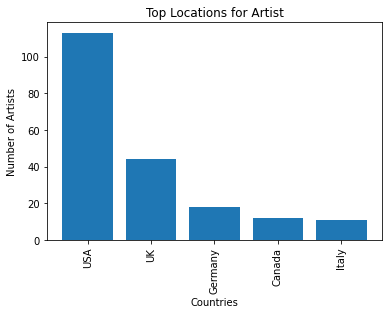

In [34]:
x = np.array(["USA", "UK", "Germany", "Canada", "Italy"])
y = np.array([113, 44, 18, 12, 11])

plt.bar(x,y)
plt.title('Top Locations for Artist')
plt.xlabel('Countries')
plt.ylabel('Number of Artists')
plt.xticks(rotation='vertical')
plt.show()


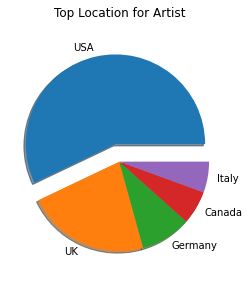

In [35]:
x = [113, 44, 18, 12, 11]
labels = ["USA", "UK", "Germany", "Canada", "Italy"]
myexplode = [0.2, 0, 0, 0, 0]

fig, ax = plt.subplots()
ax.pie(x, labels=labels, explode = myexplode, shadow = True)
ax.set_title('Top Location for Artist', y = 1.12)
plt.tight_layout()
plt.show()


## Genre Analysis

Find the mode, count, proportion of artists by genre.

#### Genre Mode

The value that appears most frequently in the genre column is Pop.

In [16]:
#The mode shows the most frequently occuring value in a column

statistics.mode(genre_dropped['genre'])

'Pop'

#### Genre Count

In [17]:
#GENRE COUNT - NULL DROPPED

#count of unique genres, excluding null values
genre_counts_dropped = genre_dropped['genre'].value_counts()

#series
genre_counts_dropped

#create dictionary and convert to df
genre_counts_dict = {'Genre Count':genre_counts_dropped}
genre_counts_df = pd.DataFrame(genre_counts_dict)

#top 10 by proportion
genre_counts_top10 = genre_counts_df.head(10)
genre_counts_top10

Genre Count
Pop                        37
Jazz                       22
Rock                       22
Hip-Hop                    19
Classical                  16
Indie                      14
Rap                        12
Electronic                 11
Alternative Rock           11
R&B                        10

#### Genre Proportion

In [18]:
#GENRE PROPORTION - NULL DROPPED

#proportion each genre represents in the data
genre_proportion_dropped = round(genre_counts_dropped / genre_counts_dropped.sum(), 3)

#series
genre_proportion_dropped

#create dictionary and convert to df
genre_proportion_dict = {'Genre Proportion':genre_proportion_dropped}
genre_proportion_df = pd.DataFrame(genre_proportion_dict)

#top 10 by proportion
genre_proportion_top10 = genre_proportion_df.head(10)
genre_proportion_top10

Genre Proportion
Pop                          0.090
Jazz                         0.054
Rock                         0.054
Hip-Hop                      0.046
Classical                    0.039
Indie                        0.034
Rap                          0.029
Electronic                   0.027
Alternative Rock             0.027
R&B                          0.024

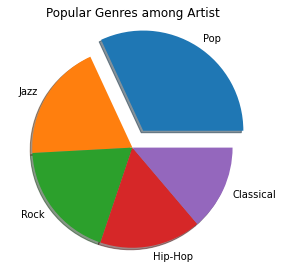

In [36]:
x = [37, 22, 22, 19, 16]
labels = ["Pop", "Jazz", "Rock", "Hip-Hop", "Classical"]
myexplode = [0.2, 0, 0, 0, 0]


fig, ax = plt.subplots()
ax.pie(x, labels=labels, explode = myexplode, shadow = True)
ax.set_title('Popular Genres among Artist')
plt.tight_layout()
plt.show()

# Pop music is the most popular among the artists

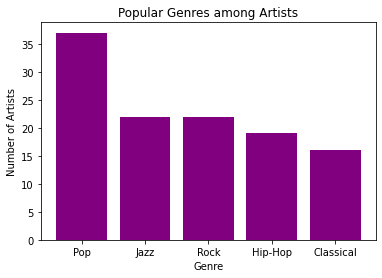

In [37]:
x = ["Pop", "Jazz", "Rock", "Hip-Hop", "Classical"]
y = [37, 22, 22, 19, 16]

plt.bar(x, y, color = "purple")
plt.title('Popular Genres among Artists')
plt.xlabel('Genre')
plt.ylabel('Number of Artists')
plt.show()

## Gender 

Find the mode, count, and proportion of artists by gender.

#### Gender Mode

Male artists and groups are more common that female or mixed gender groups.

In [21]:
statistics.mode(gender_dropped['gender'])

'Male'

#### Gender Count

In [22]:
#GENDER COUNT - NULL DROPPED

#count of unique genres, excluding null values
gender_counts_dropped = gender_dropped['gender'].value_counts()

#series
gender_counts_dropped

#create dictionary and convert to df
gender_counts_dict = {'Gender Count':gender_counts_dropped}
gender_counts_df = pd.DataFrame(gender_counts_dict)
gender_counts_df

Gender Count
Male             303
Female            95
Mixed             44

#### Gender Proportion

In [23]:
#GENDER PROPORTION - NULL DROPPED

#proportion each genre represents in the data
gender_proportion_dropped = round(gender_counts_dropped / gender_counts_dropped.sum(), 2)

#series
gender_proportion_dropped

#create dictionary and convert to df
gender_proportion_dict = {'Gender Proportion':gender_proportion_dropped}
gender_proportion_df = pd.DataFrame(gender_proportion_dict)
gender_proportion_df

Gender Proportion
Male                 0.69
Female               0.21
Mixed                0.10

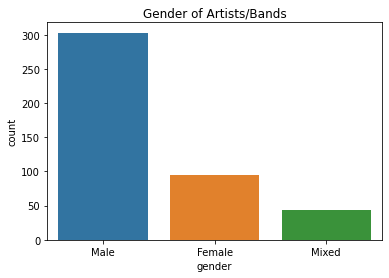

In [24]:
category_order = ['Male', 'Female', 'Mixed']

sns.countplot(x = gender_dropped['gender'], data = audio_df, order = category_order)
plt.title('Gender of Artists/Bands')
plt.show()

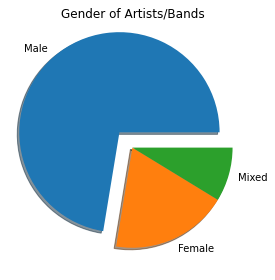

In [25]:
x = [307, 80, 37]
labels = ['Male', 'Female', 'Mixed']
myexplode = [0.2, 0, 0]

fig, ax = plt.subplots()
ax.pie(x, labels=labels, explode = myexplode, shadow = True)
ax.set_title('Gender of Artists/Bands')
plt.tight_layout()
plt.show()

## Year Formed

Find the minimum, maximum, and number of artists/bands formed per year.

In [26]:
#Find the max year
max_year_formed = year_formed_dropped['year_formed'].max()
max_year_formed

'2018'

In [27]:
#Find the max year
min_year_formed = year_formed_dropped['year_formed'].min()
min_year_formed

'1510'

In [28]:
#Find the number of band formed each year
year_count = year_formed_dropped.groupby('year_formed').size()

#create dictionary and convert to df
year_count_dict = {'Year Count':year_count}
year_count_df = pd.DataFrame(year_count_dict)
year_count_df

Year Count
year_formed            
1510                  1
1898                  1
19                    1
1904                  1
1911                  1
...                 ...
2014                  5
2015                  5
2016                  3
2017                  4
2018                  1

[89 rows x 1 columns]

## Analysis on Multiple Columns

Find the genres for the top 3 locations.

Find the years artists/bands were formed for the top 3 genres.

#### Genres by Top 3 Locations

An analysis of the genres in the top 3 countries

In [46]:
#Genre by Location
#GROUPBYS WITH NULL VALUES DROPPED

#create new vartiables = one df with null values in 'genre' and 'location' dropped
genre_location_na = location_na.replace({'genre': r'Null'}, {'genre': np.nan}, regex=True)
genre_location_dropped = genre_location_na.dropna(axis=0, subset=['genre'], inplace=False)
genre_location_na.dropna(axis=0, subset=['location'], inplace=False)
genre_location_dropped

#groupby location
genre_location_grouped = genre_location_dropped.groupby('location')

#count location by genre
genre_by_location = genre_location_grouped['genre'].value_counts()

#sort values in descending order
genre_by_location_sorted = genre_by_location.sort_values(ascending=False)

#isolate top 3 locations
genre_by_location_top3 = genre_by_location_sorted.loc[['USA', 'UK', 'Germany']]

genre_by_location_top3

#create dictionary and convert to df
genre_by_location_top3_dict = {'Genre by Location':genre_by_location_top3}
genre_by_location_top3_df = pd.DataFrame(genre_by_location_top3_dict)
genre_by_location_top3_df

Genre by Location
location genre                                
USA      Jazz                                9
         Rock                                9
         Hip-Hop                             8
         Pop                                 7
         Soul                                5
...                                        ...
Germany  Progressive Trance                  1
         R&B                                 1
         Rock                                1
         Rock & Roll                         1
         Violinist                           1

[81 rows x 1 columns]

#### Genres by Year

An analysis of the year that bands formed and the genre they play in.

In [30]:
#Genre by Year
#GROUPBYS WITH NULL VALUES DROPPED

#create new vartiables = one df with null values in 'genre' and 'year_formed' dropped
genre_year_na = genre_na.replace({'year_formed': r'Null'}, {'year_formed': np.nan}, regex=True)
genre_year_dropped = genre_year_na.dropna(axis=0, subset=['year_formed'], inplace=False)
genre_year_dropped

#groupby year formed
year_genre_grouped = genre_year_dropped.groupby('genre')

#count genre on year formed groupby
year_by_genre = year_genre_grouped['year_formed'].value_counts()

year_by_genre_top3 = year_by_genre.loc[['Pop', 'Jazz', 'Rock']]

#create dictionary and convert to df
year_by_genre_top3_dict = {'Genre by Year':year_by_genre_top3}
year_by_genre_top3_df = pd.DataFrame(year_by_genre_top3_dict)
year_by_genre_top3_df

Genre by Year
genre year_formed               
Pop   1983                     2
      1988                     2
      2011                     2
      1965                     1
      1973                     1
      1977                     1
      1979                     1
      1984                     1
      1985                     1
      1987                     1
      1989                     1
      1992                     1
      1993                     1
      1994                     1
      1995                     1
      1997                     1
      2000                     1
      2002                     1
      2007                     1
      2014                     1
      2017                     1
Jazz  1936                     1
      1942                     1
      1946                     1
      1956                     1
      1961                     1
      1976                     1
      1990                     1
Rock  1982                     2
      1961                     1
      1967                     1
      1968                     1
      1970                     1
      1974                     1
      1978                     1
      1983                     1
      1987                     1
      1988                     1
      1995                     1
      1999                     1
      2002                     1
      2007                     1
      2009                     1
      2012                     1